In [1]:
import requests
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [46]:


def tick_to_price(tick, decimals0, decimals1):
    return 1.0001 ** - tick * (10 ** (decimals1 - decimals0))

def fetch_uniswap_swaps(pool_address, total_nb_swaps, limit=1000):
    endpoint = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    query = """
    query MyQuery($pool: String!, $first: Int!, $skip: Int!) {
      swaps(
        where: {pool: $pool}
        orderBy: timestamp
        orderDirection: desc
        first: $first
        skip: $skip
      ) {
        amount0
        amount1
        amountUSD
        origin
        tick
        sqrtPriceX96
        sender
        recipient
        timestamp
        recipient
        id
        sqrtPriceX96
        tick
        token1 {
          decimals
          symbol
          volume
        }
        token0 {
          decimals
          symbol
          volume
        }
        transaction {
          gasUsed
          gasPrice
          blockNumber
          timestamp
        }
      }
    }
    """

    swaps = []
    skip = 0

    while len(pd.DataFrame(swaps)) < total_nb_swaps:
        variables = {"pool": pool_address, "first": limit, "skip": skip}
        response = requests.post(endpoint, json={'query': query, 'variables': variables})
        try:
            data = response.json()['data']['swaps']
        except:
            pass
        swaps.extend(data)
        skip += limit
        
    df = pd.DataFrame(swaps)
    
    df[['amount0', 'amount1', 'amountUSD', 'timestamp']] = df[['amount0', 'amount1', 'amountUSD', 'timestamp']].astype('float')
    df[['sender', 'recipient', 'origin']] = df[['sender', 'recipient', 'origin']].astype('str')

    df['gasUsed']  = df['transaction'].apply(lambda x: x['gasUsed']).astype('int')
    df['gasPrice_gwei'] = df['transaction'].apply(lambda x: x['gasPrice']).astype('int')
    df['gasPrice_eth'] = df['gasPrice_gwei']*10**-18
    
    df['blockNumber'] = df['transaction'].apply(lambda x: x['blockNumber']).astype('int')
    #df['timestamp'] = df['transaction'].apply(lambda x: x['timestamp']).astype('int')
    
    df['symbol0'] = df['token0'].apply(lambda x: x['symbol']).astype('str')
    df['symbol1'] = df['token1'].apply(lambda x: x['symbol']).astype('str')

    df['decimal0'] = df['token0'].apply(lambda x: x['decimals']).astype('int')
    df['decimal1'] = df['token1'].apply(lambda x: x['decimals']).astype('int')
    
    df['volume0'] = df['token0'].apply(lambda x: x['volume']).astype('float')
    df['volume1'] = df['token1'].apply(lambda x: x['volume']).astype('float')

    df['tick']  = df['tick'].astype('int')
    df['price'] = df.apply(lambda row: tick_to_price(row['tick'], row['decimal0'], row['decimal1']), axis=1)

    df['tcost_usd'] = df['gasPrice_eth']*df['price']*df['gasUsed']
    
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')

    df = df.drop(['token1', 'token0', 'tick', 'decimal0', 'decimal1', 'id', 'transaction'], axis=1)
    
    df = df.set_index('time')
    
    path = df.iloc[0].symbol1 + '_' + df.iloc[0].symbol0 + '_pool_swap-' + str(df.index[0].date()) + '_' + str(df.index[-1].date()) + '.pkl'
    df.to_pickle(path)

    return df

In [47]:
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
df = fetch_uniswap_swaps(pool_address, total_nb_swaps=10000)
df.head()

,amount0,amount1,amountUSD,origin,sqrtPriceX96,sender,recipient,timestamp,gasUsed,gasPrice_gwei,gasPrice_eth,blockNumber,symbol0,symbol1,volume0,volume1,price,tcost_usd
time,,,,,,,,,,,,,,,,,,
2024-02-12 03:48:11,1990.757600,-0.794840,1989.866124,0x5a407865411253e5a991d3e49e8bc7a1fdbe82b0,1583502060292674786291009566798661,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.707710e+09,263236,17579554013,1.757955e-08,19209364,USDC,WETH,6.930883e+11,4.278541e+08,2503.415754,11.584735
2024-02-12 03:47:59,-2212.649744,0.884318,2212.765455,0x3888f1eda9b4b946c262100938231e7c8e718d95,1583503850322451146356681716390747,0x1111111254eeb25477b68fb85ed929f73a960582,0x663dc15d3c1ac63ff12e45ab68fea3f0a883c251,1.707710e+09,469331,19940800000,1.994080e-08,19209363,USDC,WETH,6.930883e+11,4.278541e+08,2503.415754,23.429056
2024-02-12 03:47:59,497.374509,-0.198584,497.152062,0x127e4fdf8adbba482a42d3600882b4a1bb76f5cc,1583503492497405545079202446329310,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.707710e+09,231217,18027656625,1.802766e-08,19209363,USDC,WETH,6.930883e+11,4.278541e+08,2503.415754,10.434990
2024-02-12 03:47:47,306939.391317,-122.567193,306823.240313,0x0cac3d1a887206e0f6169222c4504301a8b4b993,1583502329628301909529566279305438,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,1.707710e+09,245848,18140486819,1.814049e-08,19209362,USDC,WETH,6.930883e+11,4.278541e+08,2503.415754,11.164740
2024-02-12 03:47:47,100.000000,-0.039926,99.955189,0x4d604e5b4fc66f6d34a96d7ada89774ce32ce62a,1583502257685647631839371512014686,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.707710e+09,332551,18195877692,1.819588e-08,19209362,USDC,WETH,6.930883e+11,4.278541e+08,2503.415754,15.148312


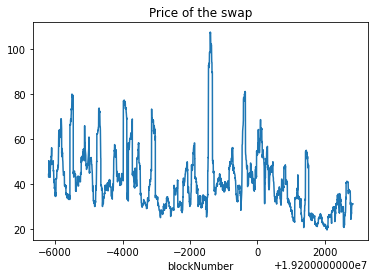

In [4]:
import matplotlib.pyplot as plt 
df.groupby('blockNumber').mean().tcost_usd.rolling(50).mean().plot()
plt.title('Price of the swap')
plt.show()

In [6]:
# those can be considered non arbitrager possibly 
# cause they need to go through the app ui to swap and there is no possibility to select whos the receiver address

print('Percent of pure guys :',round(len(df[df.sender == df.recipient])*100/len(df), 4), '%')

Percent of pure guys : 62.64 %


In [7]:
print(df.iloc[0].origin)
print(df.iloc[0].sender)

0x571baf09da284998c49a1d19bd1e9bd6386b9f55
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad


In [7]:
print('Percent of unique origines :',round(len(df.origin.unique())*100/len(df), 4), '%')
print('Percent of unique senders  :',round(len(df.sender.unique())*100/len(df), 4), '%')
print('Percent of unique recipient:',round(len(df.recipient.unique())*100/len(df), 4), '%')

Percent of unique origines : 36.39 %
Percent of unique senders  : 1.1 %
Percent of unique recipient: 10.82 %


# Dynamic fee algorithm

In [9]:
sample = df[:5]

In [12]:
sample['amount0']/sample['amount1']

time
2024-02-06 04:01:35   -2315.918054
2024-02-06 04:01:23   -2315.907658
2024-02-06 04:01:11   -2313.591824
2024-02-06 04:00:23   -2315.888237
2024-02-06 03:59:59   -2315.863302
dtype: float64

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [38]:
df_reversed = df.iloc[::-1]
df_reversed.head()

,amount0,amount1,amountUSD,origin,sqrtPriceX96,sender,recipient,timestamp,gasUsed,gasPrice_gwei,gasPrice_eth,blockNumber,symbol0,symbol1,price,tcost_usd
time,,,,,,,,,,,,,,,,
2024-02-09 23:10:59,37679.593228,-15.092962,37678.784383,0x13272487fa52088b821d30ecdfbac665daf4647c,1585996843932651758315247838397886,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.707520e+09,563823,46761319402,4.676132e-08,19193757,USDC,WETH,2495.667568,65.798543
2024-02-09 23:11:23,-38855.526632,15.579616,38874.190899,0x834160fa418b2efad19a3746ff3a34e8eec090e6,1586147617219114514140640296063394,0x1111111254fb6c44bac0bed2854e76f90643097d,0x1111111254fb6c44bac0bed2854e76f90643097d,1.707520e+09,1345271,48272660106,4.827266e-08,19193759,USDC,WETH,2495.168510,162.035768
2024-02-09 23:11:47,-902.739344,0.362000,903.216924,0xd7e1236c08731c3632519dcd1a581bfe6876a3b2,1586151120510138983703552608148419,0x24902aa0cf0000a08c0ea0b003b0c0bf600000e0,0x24902aa0cf0000a08c0ea0b003b0c0bf600000e0,1.707520e+09,386750,74700795005,7.470080e-08,19193761,USDC,WETH,2495.168510,72.086747
2024-02-09 23:11:59,-3668.048957,1.470910,3670.010013,0x9541817477e93859ed9d84483940c7bc4aee4758,1586165355390643221615385566828063,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x9541817477e93859ed9d84483940c7bc4aee4758,1.707520e+09,251275,43722893429,4.372289e-08,19193762,USDC,WETH,2495.168510,27.413094
2024-02-09 23:12:23,-24878.844067,9.977265,24893.012591,0x25968605f4ba8bd72b463e7d569586d5a3b47409,1586261581841313682147046727108365,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x25968605f4ba8bd72b463e7d569586d5a3b47409,1.707520e+09,429832,47727343308,4.772734e-08,19193764,USDC,WETH,2494.669551,51.177496


In [39]:
vol_punished, vol_total = 0, 0
bid_punished, ask_punished = 0, 0
dynamic_fees = [0]

# equal_punish_fee_constant c
c = 0.05

# iterate in natural time order 
for i in range(1, len(df_reversed)):
    row = df_reversed.iloc[i]
    # trade moves in the same direction
    if np.sign(row['amount1']) == np.sign(df_reversed['amount1'].iloc[i - 1]):
        vol_punished += np.abs(row['amount1'])
        dynamic_fees.append(row['tcost_usd'] * c)
        if row['amount1'] > 0:
            bid_punished += row['tcost_usd'] * c
        else:
            ask_punished += row['tcost_usd'] * c
    else:
        dynamic_fees.append(0)
    vol_total += np.abs(row['amount1'])
    
print(f"{(vol_punished/vol_total*100):.4f}% of the volumn will be punished by dynamic fees, resulting in {(sum(dynamic_fees)):.4f} extra fees to the LP.")
print(f"{bid_punished:.4f} are from bid; and {ask_punished:.4f} are from ask")

51.4194% of the volumn will be punished by dynamic fees, resulting in 14973.4160 extra fees to the LP.
10422.8835 are from bid; and 4550.5325 are from ask


In [31]:
df['tcost_usd'].sum()

514529.2456882855

In [43]:
df_reversed.index

DatetimeIndex(['2024-02-09 23:10:59', '2024-02-09 23:11:23',
               '2024-02-09 23:11:47', '2024-02-09 23:11:59',
               '2024-02-09 23:12:23', '2024-02-09 23:12:47',
               '2024-02-09 23:12:59', '2024-02-09 23:13:47',
               '2024-02-09 23:13:47', '2024-02-09 23:13:59',
               ...
               '2024-02-11 05:53:47', '2024-02-11 05:54:23',
               '2024-02-11 05:54:59', '2024-02-11 05:54:59',
               '2024-02-11 05:55:11', '2024-02-11 05:55:23',
               '2024-02-11 05:55:23', '2024-02-11 05:55:35',
               '2024-02-11 05:55:47', '2024-02-11 05:55:59'],
              dtype='datetime64[ns]', name='time', length=10000, freq=None)

In [44]:
dynamic_fee_df = pd.DataFrame(dynamic_fees, columns=['fee']).set_index(df_reversed.index)
dynamic_fee_df

,fee
time,
2024-02-09 23:10:59,0.000000
2024-02-09 23:11:23,0.000000
2024-02-09 23:11:47,3.604337
2024-02-09 23:11:59,1.370655
2024-02-09 23:12:23,2.558875
...,...
2024-02-11 05:55:23,0.000000
2024-02-11 05:55:23,0.000000
2024-02-11 05:55:35,14.473221


<AxesSubplot:xlabel='time'>

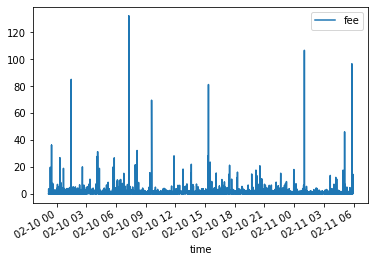

In [45]:
dynamic_fee_df.plot()

## change the constant based on Volumn and Volatility? 

In [53]:
# trading size of arbitrageursin ETH
total_volume, num_trade = 0, 0
for arbitrageur in df.sender.unique():
    print(arbitrageur)
    total_volume += df.loc[df['sender'] == arbitrageur, 'volume1'].sum()
    num_trade += df.loc[df['sender'] == arbitrageur, 'volume1'].count()
    
print(f'average trading size of arbitrageurs per swap is {(total_volume/num_trade):.4f}')

0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad
0x1111111254eeb25477b68fb85ed929f73a960582
0xdef1c0ded9bec7f1a1670819833240f027b25eff
0xa69babef1ca67a37ffaf7a485dfff3382056e78c
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
0xe37e799d5077682fa0a244d46e5649f71457bd09
0xf3de3c0d654fda23dad170f0f320a92172509127
0xe8cfad4c75a5e1caf939fd80afcf837dde340a69
0xf081470f5c6fbccf48cc4e5b82dd926409dcdd67
0xe592427a0aece92de3edee1f18e0157c05861564
0x7174b67526dafb2dd1d6daabf3b5783c7090d15c
0x03f911aedc25c770e701b8f563e8102cfacd62c0
0x5c9321e92ba4eb43f2901c4952358e132163a85a
0x3face0004bc1003b9d0672e7b23134cb80115fb6
0xdea6fdea0471ce1545331b7b93fdbd43786fa4c2
0x6f1cdbbb4d53d226cf4b917bf768b94acbab6168
0x00000000032962b51589768828ad878876299e14
0x2deae6ce94d65ac1de19a1fc4bb160c4e02c92ef
0xd129d8c12f0e7aa51157d9e6cc3f7ece2dc84ecd
0xbc2c6cd5013585ac720160efcb1feced30837177
0xd19dc09880685dd8cf60687d57936358582876b5
0x767c8bb1574bee5d4fe35e27e0003c89d43c5121
0x00000000009e50a7ddb7a7b0e2ee6604fd120e49
0x5079fc00f

In [55]:
df.loc[df['sender'] == "0x01bd2da640345f1c29831b7cef9a434298408172", 'volume1']

time
2024-02-10 23:13:11    4.278541e+08
2024-02-10 23:13:11    4.278541e+08
2024-02-10 23:13:11    4.278541e+08
2024-02-10 23:13:11    4.278541e+08
2024-02-10 23:13:11    4.278541e+08
Name: volume1, dtype: float64

In [56]:
df['volume1'].describe()

count    1.000000e+04
mean     4.278541e+08
std      7.611894e-05
min      4.278541e+08
25%      4.278541e+08
50%      4.278541e+08
75%      4.278541e+08
max      4.278541e+08
Name: volume1, dtype: float64